# Twitter Sentiment Analysis

Dataset: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

Paper: https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf

Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.



Columns:

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

In [1]:
# Libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Constants
TRAIN_DATA_NAME = 'sentiment140/training.1600000.processed.noemoticon.csv'
TRAIN_COLUMN_NAMES = ['sentiment', 'id', 'date', 'flag', 'user', 'tweet']

ENCODING = 'latin-1'
NROWS = 1600000

In [3]:
pd.options.display.max_colwidth = None

# Load Dataset into Dataframe
df = pd.read_csv(TRAIN_DATA_NAME,
                 encoding=ENCODING,
                 header=None,
                 names=TRAIN_COLUMN_NAMES,
                 nrows=NROWS,
                 parse_dates=['date'])
df.head(5)

C:\Users\Anne\AppData\Local\Temp\ipykernel_15452\2308195955.py:4: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df = pd.read_csv(TRAIN_DATA_NAME,


,sentiment,id,date,flag,user,tweet
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


## Train Data EDA

In [4]:
# General Info about Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   sentiment  1600000 non-null  int64         
 1   id         1600000 non-null  int64         
 2   date       1600000 non-null  datetime64[ns]
 3   flag       1600000 non-null  object        
 4   user       1600000 non-null  object        
 5   tweet      1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 73.2+ MB


#### Sentiment column

In [5]:
df.sentiment.value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

#### id column

In [6]:
print(df.id.value_counts())

# Number of ids with 2 entries
print('Number of ids with 2 entries: ', len(df.id.value_counts().reset_index()[df.id.value_counts().reset_index()['count'] > 1]))

# Example of one such id
df[df['id'] == 1989776729]

id
2190457769    2
1972193428    2
1989776729    2
1989776908    2
1564543229    2
             ..
2197311196    1
2197311146    1
2197310899    1
2197310477    1
2193602129    1
Name: count, Length: 1598315, dtype: int64
Number of ids with 2 entries:  1685


,sentiment,id,date,flag,user,tweet
270201,0,1989776729,2009-06-01 02:46:20,NO_QUERY,mam1cutie,@Dog_Crazy Sorry yest was bad day for your mom! I hope today is a better day for her! I gotta go get ready for work - blah. lol
1217853,4,1989776729,2009-06-01 02:46:20,NO_QUERY,mam1cutie,@Dog_Crazy Sorry yest was bad day for your mom! I hope today is a better day for her! I gotta go get ready for work - blah. lol


=> There are some duplicate tweets with different sentiments.

#### Date column

In [7]:
df.date.dtype

dtype('<M8[ns]')

In [8]:
# Change date format and shift to UTF time
df.date = df.date.apply(lambda date : date.tz_localize(tz='US/Pacific').tz_convert('UTC'))

<Axes: xlabel='date'>

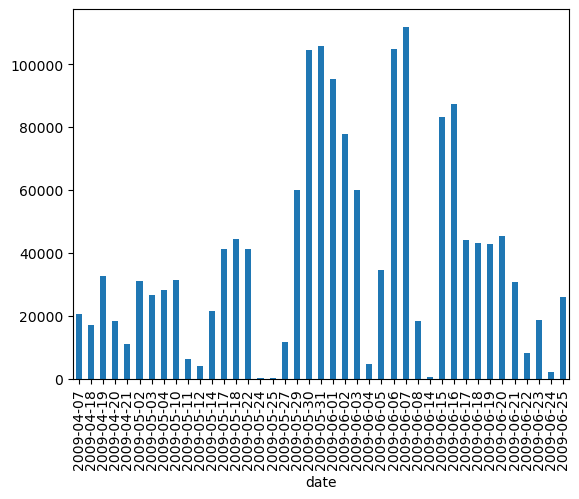

In [9]:
# Plot the number of tweets per date
df.tweet.groupby(df.date.dt.date).count().plot(kind='bar')

#### flag column

In [10]:
df.flag.value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

#### user column

In [11]:
df.user.value_counts()

user
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
67trinity            1
Sibby                1
mAnyA_15             1
49ersfan111          1
bpbabe               1
Name: count, Length: 659775, dtype: int64

#### tweet column

In [12]:
df.tweet.value_counts()

tweet
isPlayer Has Died! Sorry                                                                              210
good morning                                                                                          118
headache                                                                                              115
Good morning                                                                                          112
Headache                                                                                              106
                                                                                                     ... 
braces  tell me it will be okay...                                                                      1
is stuck at home without curry                                                                          1
@mrsduryee I've applied to about 70 since I lost my job in March...it certainly FEELS like a lot!       1
The cheese I got @SarawithanR lost its s

In [13]:
# How many tweets are there exactly twice?
df.tweet.value_counts().reset_index()[(df.tweet.value_counts().reset_index()['count'] > 1) & (df.tweet.value_counts().reset_index()['count'] < 3)]

,tweet,count
2284,tomorrow i prepare to fail I don't understand any of it can't wait until its ok though,2
2285,@ddlovato hey demi! Say hi to me! Please??Just 1 Hi then my day will be colorfull than yesterday!,2
2286,I have a chocolate soy milk problem.,2
2287,bored out my mind,2
2288,finally got my laptop back,2
...,...,...
8429,trying to figure this twitter thing out,2
8430,@shinzofukui,2
8431,I want breakfast,2
8432,"@Knot2serious Loving a GR8 wkend here in Sedona! Beautiful, even though I had to work on my house How are U? Dont kick them 2 hard",2


In [14]:
# unnötige Spalten löschen
df.drop(columns=['id', 'date', 'flag', 'user'], inplace=True)
df

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...
1599995,4,Just woke up. Having no school is the best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


In [15]:
df.to_csv('sentiment140/sentiment140_training.csv', index=False)

## Test Datensatz

In [16]:
# Constants
TEST_DATA_NAME = 'sentiment140/testdata.manual.2009.06.14.csv'
TEST_COLUMN_NAMES = ['sentiment', 'id', 'date', 'query', 'user', 'tweets']

ENCODING = 'latin-1'
NROWS = 1600000

test_df = pd.read_csv(TEST_DATA_NAME,
                 encoding=ENCODING,
                 header=None,
                 names=TEST_COLUMN_NAMES,
                 nrows=NROWS,
                 parse_dates=['date'])
test_df.head(5)

,sentiment,id,date,query,user,tweets
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)


#### EDA Test Datensatz

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  498 non-null    int64 
 1   id         498 non-null    int64 
 2   date       498 non-null    object
 3   query      498 non-null    object
 4   user       498 non-null    object
 5   tweets     498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


#### Sentiment column

Sentiment codierung:
- 0: Negative
- 2: Neutral
- 4: Positive

In [18]:
test_df.sentiment.value_counts()

sentiment
4    182
0    177
2    139
Name: count, dtype: int64

Der Trainingsdatensatz enthält keine Datensätze mit sentiment = 2, somit löschen wir diese Datensätze.

In [19]:
test_df.drop(test_df[test_df.sentiment == 2].index, inplace=True)
test_df

,sentiment,id,date,query,user,tweets
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)
...,...,...,...,...,...,...
492,4,14071,Sun Jun 14 04:31:28 UTC 2009,latex,yomcat,"After using LaTeX a lot, any other typeset mathematics just looks hideous."
494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hate LaTeX. There, I said it. I hate LaTeX. All you TEXN3RDS can come kill me now."
495,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environment. I &lt;3 LaTeX.
496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far away. #flockofseagullsweregeopoliticallycorrect"


In [20]:
test_df.sentiment.value_counts()/test_df.sentiment.shape[0]

sentiment
4    0.506964
0    0.493036
Name: count, dtype: float64

Der Datensatz ist immer noch knapp 50% positives und 50% negatives sentiment.

In [21]:
test_df.shape

(359, 6)

Der Testdatensatz enthält nur noch 359 Zeilen.

#### Tweets column

In [22]:
len(test_df.tweets.unique()) == test_df.shape[0]

True

Es gibt keine doppelten Tweets im Testdatensatz.

#### Drop columns and Save
Nicht gebrauchte Spalten können gelöscht werden und der resultierende DataFrame wird gepspeichert

In [23]:
# unnötige Spalten löschen
test_df.drop(columns=['id', 'date', 'query', 'user'], inplace=True)
test_df

,sentiment,tweets
0,4,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)
...,...,...
492,4,"After using LaTeX a lot, any other typeset mathematics just looks hideous."
494,0,"On that note, I hate Word. I hate Pages. I hate LaTeX. There, I said it. I hate LaTeX. All you TEXN3RDS can come kill me now."
495,4,Ahhh... back in a *real* text editing environment. I &lt;3 LaTeX.
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far away. #flockofseagullsweregeopoliticallycorrect"


In [24]:
test_df.to_csv('sentiment140/sentiment140_test.csv', index=False)

## Data Cleaning / Preparation

Remove
- mentions,
- hashtags,
- URLs,
- other special characters except "'"   

Convert everything to lowercase

In [29]:
def clean_tweet(tweet):
  tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
  tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
  tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
  tweet = re.sub(r'[^A-Za-z0-9\']+', ' ', tweet)
  return tweet.lower().strip()

df['cleaned_tweet'] = df.tweet.apply(lambda x : clean_tweet(x))

TODO:  letter occurring more than two times in a row -> replaced with two occurrences (e.g. huuuungry, huuuuuuungry, huuuuuuuuuungry)

Remove stopwords

In [30]:
stop_words = stopwords.words('english')

In [31]:
#stop_words

=> What about stopwords like "not"?

In [32]:
def remove_stopwords(tweet):
  tweet = [word for word in tweet.split() if word not in stop_words]
  return ' '.join(tweet)

df['no_stop_cleaned_tweet'] = df.cleaned_tweet.apply(lambda x : remove_stopwords(x))

Tokenize the cleaned tweets (without stopwords)

In [33]:
def tokenize(tweet):
  tweet = nltk.word_tokenize(tweet)
  return tweet

df['tokenized_tweet'] = df.no_stop_cleaned_tweet.apply(lambda x : tokenize(x))
df.tokenized_tweet

0                                     [awww, that, 's, bummer, shoulda, got, david, carr, third, day]
1          [upset, ca, n't, update, facebook, texting, might, cry, result, school, today, also, blah]
2                                     [dived, many, times, ball, managed, save, 50, rest, go, bounds]
3                                                             [whole, body, feels, itchy, like, fire]
4                                                                [behaving, i, 'm, mad, ca, n't, see]
                                                      ...                                            
1599995                                                           [woke, school, best, feeling, ever]
1599996                                              [thewdb, com, cool, hear, old, walt, interviews]
1599997                                                         [ready, mojo, makeover, ask, details]
1599998                                [happy, 38th, birthday, boo, alll, time, tu

Lemmatize or Stemm the tokenized tweets

In [34]:
def stemmer(tweet):
  stemmer = PorterStemmer()
  tweet = [stemmer.stem(word) for word in tweet]
  return tweet


df['stem_tweet'] = df.tokenized_tweet.apply(lambda x : ' '.join(stemmer(x)))
df.stem_tweet

0                              awww that 's bummer shoulda got david carr third day
1          upset ca n't updat facebook text might cri result school today also blah
2                                   dive mani time ball manag save 50 rest go bound
3                                                   whole bodi feel itchi like fire
4                                                         behav i 'm mad ca n't see
                                             ...                                   
1599995                                                  woke school best feel ever
1599996                                     thewdb com cool hear old walt interview
1599997                                                readi mojo makeov ask detail
1599998                        happi 38th birthday boo alll time tupac amaru shakur
1599999                                                                       happi
Name: stem_tweet, Length: 1600000, dtype: object

In [35]:
def lemmatizer(tweet):
  lemmatizer = WordNetLemmatizer()
  tweet = [lemmatizer.lemmatize(word) for word in tweet]
  return tweet


df['lem_tweet'] = df.tokenized_tweet.apply(lambda x : ' '.join(lemmatizer(x)))
df.lem_tweet

0                                  awww that 's bummer shoulda got david carr third day
1          upset ca n't update facebook texting might cry result school today also blah
2                                    dived many time ball managed save 50 rest go bound
3                                                       whole body feel itchy like fire
4                                                          behaving i 'm mad ca n't see
                                               ...                                     
1599995                                                   woke school best feeling ever
1599996                                         thewdb com cool hear old walt interview
1599997                                                  ready mojo makeover ask detail
1599998                            happy 38th birthday boo alll time tupac amaru shakur
1599999                                                                           happy
Name: lem_tweet, Length: 1600000

Result:
Comparison between the original tweet and the lemmatized tweet

In [36]:
df[['tweet', 'lem_tweet']]

,tweet,lem_tweet
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww that 's bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset ca n't update facebook texting might cry result school today also blah
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived many time ball managed save 50 rest go bound
3,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving i 'm mad ca n't see
...,...,...
1599995,Just woke up. Having no school is the best feeling ever,woke school best feeling ever
1599996,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta,thewdb com cool hear old walt interview
1599997,Are you ready for your MoJo Makeover? Ask me for details,ready mojo makeover ask detail
1599998,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur,happy 38th birthday boo alll time tupac amaru shakur


Save Dataframe to a .csv file

In [37]:
df.to_csv('sentiment140_prepared.csv', index=False)